# RLにおけるKLとエントロピー正則化

強化学習アルゴリズムではKLやエントロピー正則化がよく出てきます。
この正則化を導入すると、アルゴリズムにどのような違いが生じるでしょうか？
今回は強化学習と正則化の理論について見ていきます。

参考：

* [Leverage the Average: an Analysis of KL Regularization in Reinforcement Learning](https://arxiv.org/abs/2003.14089)
* [Theoretical Analysis of Efficiency and Robustness of Softmax and Gap-Increasing Operators in Reinforcement Learning](https://proceedings.mlr.press/v89/kozuno19a.html)
* [Tsallis Reinforcement Learning: A Unified Framework for Maximum Entropy Reinforcement Learning](https://arxiv.org/abs/1902.00137)

## 方策更新でのエントロピー正則化

[RL_multi_step.ipynb](RL_multi_step.ipynb)でも説明しましたが、強化学習の基本は``方策評価``と``方策更新``にあります。
そして、正則化をそのどちらかもしくは両方に導入することで、強化学習アルゴリズムの誤差に対する頑健性を著しく向上することが理論的に可能です。
まずは``方策更新``側に正則化が入っている場合の理論を見てみましょう。

参考
* [Theoretical Analysis of Efficiency and Robustness of Softmax and Gap-Increasing Operators in Reinforcement Learning](https://proceedings.mlr.press/v89/kozuno19a.html)
* [Leverage the Average: an Analysis of KL Regularization in Reinforcement Learning](https://arxiv.org/abs/2003.14089)
* [Convex Optimization](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf)

まず次の貪欲方策を見てみましょう。これはQ学習系のアルゴリズムでよく使われます（e.g., DQN, DDPG）

$$\mathcal{G}(q) = \argmax_{\pi} \langle q, \pi \rangle$$

貪欲方策はQ値が最大の行動だけがサンプルされるように確率を割り当てます。
この貪欲方策は単純ですが、あまり誤差に強くありません。(TODO: 参考文献)

これを緩和するために、次のように正則化を導入した更新則を考えることができます。

$$\mathcal{G}(q) = \argmax_{\pi} \langle q, \pi \rangle$$

TODO: これの正当化。貪欲方策を考えるといいことがあるのか？
**ルジャンドル変換**を使うと更新式をきれいに書くことができます。見てみましょう。

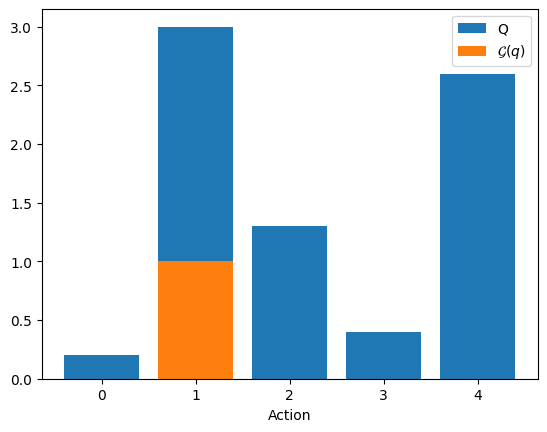

In [11]:
import numpy as np
import matplotlib.pyplot as plt

A = 5
actions = np.arange(A)
q = [0.2, 3.0, 1.3, 0.4, 2.6]
Gq = np.zeros(A)
Gq[np.argmax(q)] = 1.0

plt.bar(actions, q, label="Q")
plt.bar(actions, Gq, label=r"$\mathcal{G}(q)$")

plt.xlabel("Action")
plt.legend()


これは
次のように、方策更新と方策評価のそれぞれについてKLやエントロピー正則化が入ったアルゴリズムを見ていきます。

* KLとエントロピー正則化のもとでの貪欲方策：$\mathcal{G}^{\lambda, \tau}_{\mu}(q) = \argmax_{\pi} \langle q, \pi \rangle - \lambda \mathrm{KL}(\pi \| \mu) + \tau \mathcal{H}(\pi)$
* KLとエントロピー正則化のもとでのベルマン期待作用素：$T_{\pi | \mu}^{\lambda, \tau} q = r + \gamma P (\langle \pi, q\rangle - \lambda \mathrm{KL}(\pi \| \mu) + \tau \mathcal{H}(\pi))$

簡単のため、行動空間が有限であり、期待値が厳密に計算できる場合を考えましょう。
このとき、KLダイバージェンスやエントロピーは簡単に計算することができます。そのため、ベルマン期待作用素の計算は簡単に計算できます。では、正則化がある場合の貪欲方策はどうでしょうか？$\argmax$の中にKLやエントロピーが入っているので、一見すると厄介な計算に見えます。

実は、凸共役の性質（ルジャンドル変換）を上手く使うと、KLとエントロピーによって正則化された貪欲方策は解析解が求まります。

---

**ルジャンドル変換とエントロピー正則化**



## KLとエントロピーとルジャンドル変換

参考
* [Leverage the Average: an Analysis of KL Regularization in Reinforcement Learning](https://arxiv.org/abs/2003.14089)

表記
* $q$についての貪欲方策：$\mathcal{G}(q) = \argmax_{\pi} \langle q, \pi \rangle$
* ベルマン期待作用素：$T_\pi q = r + \gamma P_{\pi} q$
* KLとエントロピー正則化のもとでの貪欲方策：$\mathcal{G}^{\lambda, \tau}_{\mu}(q) = \argmax_{\pi} \langle q, \pi \rangle - \lambda \mathrm{KL}(\pi \| \mu) + \tau \mathcal{H}(\pi)$
* KLとエントロピー正則化のもとでのベルマン期待作用素：$T_{\pi | \mu}^{\lambda, \tau} q = r + \gamma P (\langle \pi, q\rangle - \lambda \mathrm{KL}(\pi \| \mu) + \tau \mathcal{H}(\pi))$

---

**Approximate Modified Policy Iteration**

Approximate Modified Policy Iteration (AMPI) は動的計画法の漸近的な挙動が誤差にどれくらい影響されるかを解析するためのフレームワークです。
[Approximate modified policy iteration and its application to the game of tetris](https://mohammadghavamzadeh.github.io/PUBLICATIONS/jmlr-ampi.pdf)などが参考になります。

今回は「Q関数の更新にのみ」誤差が乗った形を考えます。方策側にも誤差が乗ると解析が難しくなります。
AMPIは次の更新を繰り返します。

$$
\begin{cases}
\pi_{k+1} \in \mathcal{G}(q_k) \\
q_{k+1} = (T_{\pi_{k+1}})^m q_k + \epsilon_{k+1}
\end{cases}
$$

* $m=1$のとき：**Approximate Value Iteration**と呼ばれます。
* $m=\infty$のとき：**Approximate Policy Iteration**と呼ばれます。
* $\epsilon_k$はなんらかの近似誤差です。
  * 例えばDQNなら１ステップ回帰に伴う誤差になります。
  * $m$ステップ回帰を回した場合、$m>1$に相当します。

---

---

**Mirror Descent MPI**

TODO: 名前の由来やFrank wolfとの関連
AMPIにKLとエントロピー正則化が乗ったアルゴリズムはMirror Descent MPI (MD-MPI) と呼ばれます。

MD-MPIは次の更新を繰り返します。

$$
\begin{cases}
\pi_{k+1} \in \mathcal{G}^{\lambda, \tau}_{\pi_k}(q_k) \\
q_{k+1} = (T^{\lambda, \tau}_{\pi_{k+1} | \pi_{k}})^m q_k + \epsilon_{k+1}
\end{cases}
$$


---

## 動的計画法での誤差頑健性　

## Tabularでの解析

## Linearの解析